#EDA

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
dataset = pd.read_csv('/content/Churn_Modelling.csv')

In [ ]:
dataset.shape

(10000, 14)

In [ ]:
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

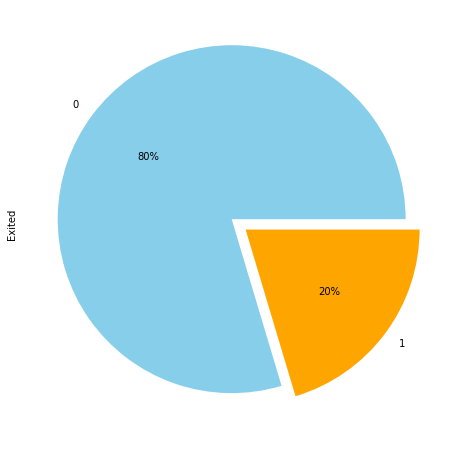

In [ ]:
dataset.Exited.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

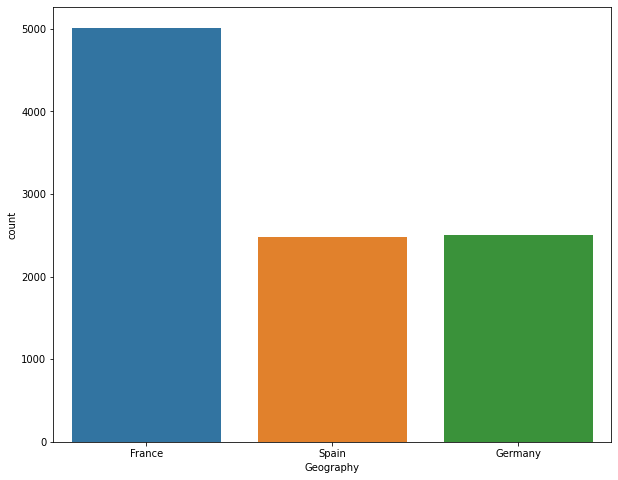

In [ ]:
sns.countplot(x='Geography', data=dataset)

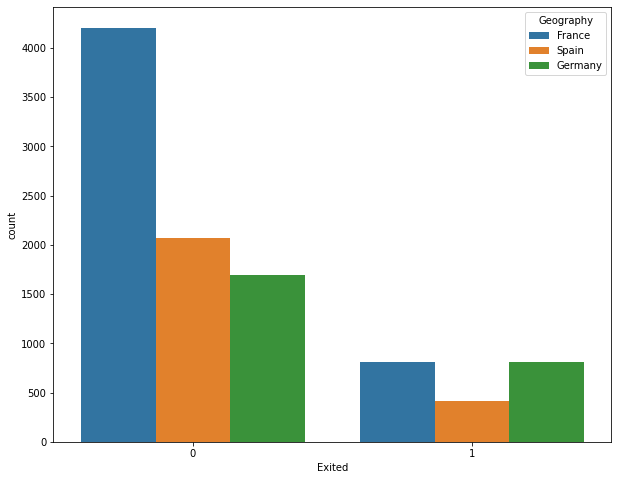

In [ ]:
sns.countplot(x='Exited', hue='Geography', data=dataset)

#Data preprocessing

In [ ]:
dataset.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [ ]:
categorical_columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

In [ ]:
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [ ]:
outputs = ['Exited']

In [ ]:
dataset.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [ ]:
for category in categorical_columns:
    dataset[category] = dataset[category].astype('category')

In [ ]:
dataset.dtypes

RowNumber             int64
CustomerId            int64
Surname              object
CreditScore           int64
Geography          category
Gender             category
Age                   int64
Tenure                int64
Balance             float64
NumOfProducts         int64
HasCrCard          category
IsActiveMember     category
EstimatedSalary     float64
Exited                int64
dtype: object

In [ ]:
dataset['Geography'].cat.categories

Index(['France', 'Germany', 'Spain'], dtype='object')

In [ ]:
dataset['Geography'].head()

0    France
1     Spain
2    France
3    France
4     Spain
Name: Geography, dtype: category
Categories (3, object): [France, Germany, Spain]

In [ ]:
dataset['Geography'].head().cat.codes

0    0
1    2
2    0
3    0
4    2
dtype: int8

In [ ]:
geo = dataset['Geography'].cat.codes.values
gen = dataset['Gender'].cat.codes.values
hcc = dataset['HasCrCard'].cat.codes.values
iam = dataset['IsActiveMember'].cat.codes.values

categorical_data = np.stack([geo, gen, hcc, iam], 1)

categorical_data[:10]

array([[0, 0, 1, 1],
       [2, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 0],
       [2, 0, 1, 1],
       [2, 1, 1, 0],
       [0, 1, 1, 1],
       [1, 0, 1, 0],
       [0, 1, 0, 1],
       [0, 1, 1, 1]], dtype=int8)

In [ ]:
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

tensor([[0, 0, 1, 1],
        [2, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 0, 0],
        [2, 0, 1, 1],
        [2, 1, 1, 0],
        [0, 1, 1, 1],
        [1, 0, 1, 0],
        [0, 1, 0, 1],
        [0, 1, 1, 1]])

In [ ]:
numerical_data = np.stack([dataset[col].values for col in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)
numerical_data[:5]

tensor([[6.1900e+02, 4.2000e+01, 2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0135e+05],
        [6.0800e+02, 4.1000e+01, 1.0000e+00, 8.3808e+04, 1.0000e+00, 1.1254e+05],
        [5.0200e+02, 4.2000e+01, 8.0000e+00, 1.5966e+05, 3.0000e+00, 1.1393e+05],
        [6.9900e+02, 3.9000e+01, 1.0000e+00, 0.0000e+00, 2.0000e+00, 9.3827e+04],
        [8.5000e+02, 4.3000e+01, 2.0000e+00, 1.2551e+05, 1.0000e+00, 7.9084e+04]])

In [ ]:
outputs = torch.tensor(dataset[outputs].values).flatten()
outputs[:5]

tensor([1, 0, 1, 0, 0])

In [ ]:
print(categorical_data.shape)
print(numerical_data.shape)
print(outputs.shape)

torch.Size([10000, 4])
torch.Size([10000, 6])
torch.Size([10000])


In [ ]:
categorical_column_sizes = [len(dataset[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(3, 2), (2, 1), (2, 1), (2, 1)]


In [ ]:
total_records = 10000
test_records = int(total_records * .2)

categorical_train_data = categorical_data[:total_records-test_records]
categorical_test_data = categorical_data[total_records-test_records:total_records]
numerical_train_data = numerical_data[:total_records-test_records]
numerical_test_data = numerical_data[total_records-test_records:total_records]
train_outputs = outputs[:total_records-test_records]
test_outputs = outputs[total_records-test_records:total_records]

In [ ]:
print(len(categorical_train_data))
print(len(numerical_train_data))
print(len(train_outputs))

print(len(categorical_test_data))
print(len(numerical_test_data))
print(len(test_outputs))

8000
8000
8000
2000
2000
2000


In [ ]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return x

Training the model

In [ ]:
model = Model(categorical_embedding_sizes, numerical_data.shape[1], 2, [200,100,50], p=0.3)

In [ ]:
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(2, 1)
    (2): Embedding(2, 1)
    (3): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.3, inplace=False)
  (batch_norm_num): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=11, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_featu

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 400
aggregated_losses = []

for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data, numerical_train_data)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.76056707
epoch:  26 loss: 0.53819007
epoch:  51 loss: 0.47412202
epoch:  76 loss: 0.42109761
epoch: 101 loss: 0.38185501
epoch: 126 loss: 0.36128634
epoch: 151 loss: 0.35991305
epoch: 176 loss: 0.35000774
epoch: 201 loss: 0.34529734
epoch: 226 loss: 0.34508049
epoch: 251 loss: 0.34562096
epoch: 276 loss: 0.33984154
epoch: 301 loss: 0.33628133
epoch: 326 loss: 0.33658877
epoch: 351 loss: 0.33643073
epoch: 376 loss: 0.32958046
epoch: 400 loss: 0.3246635497


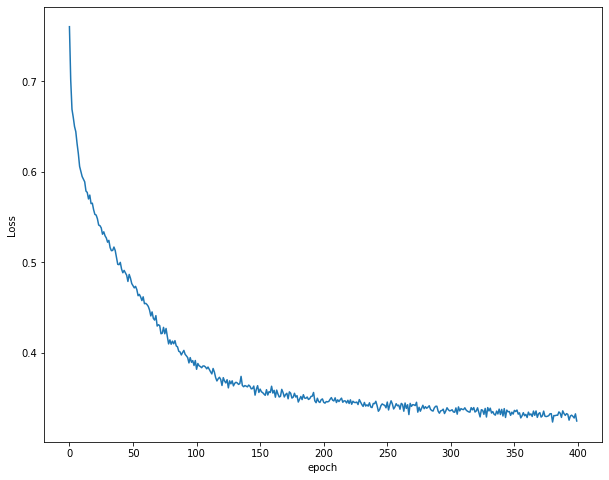

In [ ]:
plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

Make predictions

In [ ]:
with torch.no_grad():
    y_val = model(categorical_test_data, numerical_test_data)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 0.36259192


In [ ]:
print(y_val[:5])

tensor([[ 0.9649, -2.9093],
        [ 0.9439, -2.5166],
        [ 1.2977, -2.0525],
        [ 0.6637, -0.7329],
        [ 3.1061, -1.4384]])


In [ ]:
y_val = np.argmax(y_val, axis=1)

In [ ]:
print(y_val[:5])

tensor([0, 0, 0, 0, 0])


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(test_outputs,y_val))
print(classification_report(test_outputs,y_val))
print(accuracy_score(test_outputs, y_val))

[[1540   70]
 [ 220  170]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.91      1610
           1       0.71      0.44      0.54       390

    accuracy                           0.85      2000
   macro avg       0.79      0.70      0.73      2000
weighted avg       0.84      0.85      0.84      2000

0.855
